## № 1

Consider a familiar LDS, but this time with non-stationary variance of the noise:
$$
x_{t}=x_{t-1} + u_{t-1} + \epsilon_{t-1},\quad z_{t}=x_{t} + \eta_{t}
$$
with $\epsilon_t\sim\mathcal{N}(0,\sigma_t)$ and $P(\eta_t)\sim\mathcal{N}(0,\rho_t)$. 
Using all data available in `10_1.pickle` [pickled dict of $u_t$, $\sigma_t$ and $\rho_t$], compute the smoothed trajectory of the hidden state $x_t$. Plot it as a function of time together with the error bar. Compute the prediction for the location of the object at $T+1$ (that is for the time instant, following the latest available observation).

In [2]:
import pickle
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
with open('10_1.pickle', 'rb') as file:
    data = pickle.load(file)
data.keys()

dict_keys(['u', 'sigma', 'rho', 'z'])

In [4]:
{key: data[key].shape for key in data}

{'u': (1000,), 'sigma': (1000,), 'rho': (1000,), 'z': (1000,)}

Применим с незначительными изменениями код из задачи 9.5, чтобы отразить тот факт, что $\sigma$ и $\rho$ теперь массивы.

Система:
$$
\begin{pmatrix}
\rho_0^{-2} + \sigma_0^{-2} & - \sigma_0^{-2} & 0 & \cdots & 0 \\
-\sigma_0^{-2} & \sigma_0^{-2} + \rho_1^{-2} + \sigma_1^{-2} & 0 & \cdots & 0 \\
0 & -\sigma_1^{-2} & \sigma_1^{-2} + \rho_2^{-2} + \sigma_2^{-2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \sigma_{T-2}^{-2} + \rho_{T-1}^{-2}
\end{pmatrix}
\begin{pmatrix}
x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_{T-1}
\end{pmatrix}
=
\begin{pmatrix}
\frac{z_0}{\rho_0^2} - \frac{u_0}{\sigma_0^2} \\
\frac{u_0}{\sigma_0^2} + \frac{z_1}{\rho_1^2} - \frac{u_1}{\sigma_1^2} \\
\frac{u_1}{\sigma_1^2} + \frac{z_2}{\rho_2^2} - \frac{u_0}{\sigma_2^2} \\
\vdots \\
\frac{u_{T-2}}{\sigma_{T-2}^2} + \frac{z_{T-1}}{\rho_{T-1}^2}
\end{pmatrix}
$$

In [5]:
np.roll([1, 2, 3], 1)

array([3, 1, 2])

In [9]:
def kalman_smoother(u, z, sigma, rho):
    lower_diagonal = -sigma**-2
    lower_diagonal[-1] = 0

    upper_diagonal = np.roll(lower_diagonal, 1)

    main_diagonal = rho**-2 - upper_diagonal - lower_diagonal

    rhs = np.roll(u, 1) * lower_diagonal + z / rho**2 - u * upper_diagonal
    return scipy.linalg.solve_banded((1, 1), [upper_diagonal, main_diagonal, lower_diagonal], rhs)

In [14]:
def kalman_cov(sigma, rho):
    lower_diagonal = -sigma**-2
    lower_diagonal[-1] = 0

    upper_diagonal = np.roll(lower_diagonal, 1)

    main_diagonal = rho**-2 - upper_diagonal - lower_diagonal

    hessian = scipy.sparse.diags([upper_diagonal[1:], main_diagonal, lower_diagonal[:-1]], [1, 0, -1], format = 'csc')
    return scipy.sparse.linalg.inv(hessian)

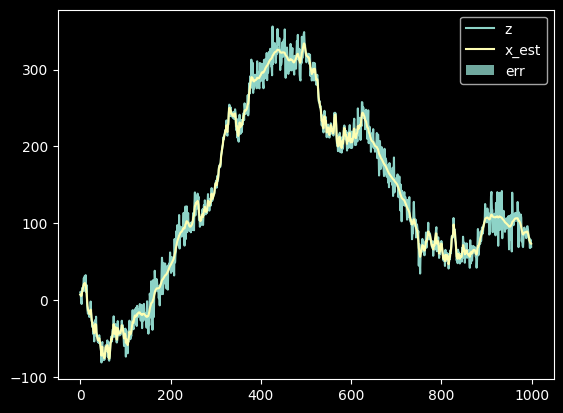

In [15]:
x_est = kalman_smoother(**data)
errs2 = kalman_cov(data['sigma'], data['rho']).diagonal()

plt.plot(data['z'], label = 'z')
plt.plot(x_est, label = 'x_est')
plt.fill_between(np.arange(len(data['z'])), x_est - np.sqrt(errs2), x_est + np.sqrt(errs2), alpha = 0.8, label = 'err')
plt.legend()

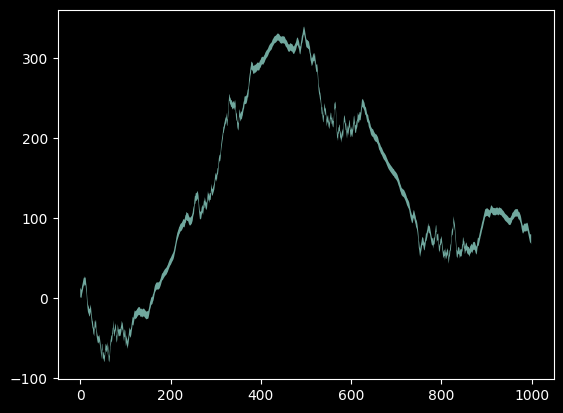

In [16]:
# Ошибку не было видно
plt.fill_between(np.arange(len(data['z'])), x_est - np.sqrt(errs2), x_est + np.sqrt(errs2), alpha = 0.8)

Чтобы вычислить значение в точке $T$, нужно просто прибавить к $x_{T-1}$ значение $u_{T-1}$:

In [17]:
x_est[-1] + data['u'][-1]

73.35738583761363